In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
input_shape = (224, 224, 3)
num_classes = 2
batch_size = 32
epochs = 20
lr = 0.01

In [23]:
# Set the paths to the training, test and validation data directories
train_dir = 'data/MSID_BINARY_AUG_SP/train'
val_dir = 'data/MSID_BINARY_AUG_SP/val'

In [24]:
# Create an instance of the ImageDataGenerator class for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

# Create an instance of the ImageDataGenerator class for validation data (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)


# Load the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
)

# Load the validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
)

Found 4846 images belonging to 2 classes.
Found 1384 images belonging to 2 classes.


In [25]:
# Load the MobileNetV2 model with pre-trained weights on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a dense layer with 128 neurons and ReLU activation
x = Dense(128, activation='relu')(x)

# Add a final dense layer with 1 neuron for binary classification and sigmoid activation
predictions = Dense(1, activation='sigmoid')(x)

# Create the new model with the modified architecture
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the weights of the base model to avoid overfitting on small datasets
for layer in base_model.layers:
    layer.trainable = False
    
# Compile the model with categorical cross-entropy loss and the SGD optimizer
optimizer = SGD(learning_rate=lr)            
                                    
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [26]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [27]:
# Set up the learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7)

# Train the model using fit_generator with the learning rate schedule
model.fit(
    train_generator, 
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_generator, 
    callbacks=[reduce_lr], 
    verbose=1)

Epoch 1/20


2023-06-08 16:38:06.661471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


152/152 [==============================] - ETA: 0s - loss: 0.4199 - accuracy: 0.8122

2023-06-08 16:38:33.820849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


152/152 [==============================] - 35s 226ms/step - loss: 0.4199 - accuracy: 0.8122 - val_loss: 0.3146 - val_accuracy: 0.8873 - lr: 0.0100
Epoch 2/20
152/152 [==============================] - 33s 215ms/step - loss: 0.2886 - accuracy: 0.8921 - val_loss: 0.2622 - val_accuracy: 0.8996 - lr: 0.0100
Epoch 3/20
152/152 [==============================] - 33s 216ms/step - loss: 0.2407 - accuracy: 0.9061 - val_loss: 0.2278 - val_accuracy: 0.9169 - lr: 0.0100
Epoch 4/20
152/152 [==============================] - 33s 218ms/step - loss: 0.2084 - accuracy: 0.9203 - val_loss: 0.2090 - val_accuracy: 0.9227 - lr: 0.0100
Epoch 5/20
152/152 [==============================] - 33s 218ms/step - loss: 0.1841 - accuracy: 0.9340 - val_loss: 0.1912 - val_accuracy: 0.9270 - lr: 0.0100
Epoch 6/20
152/152 [==============================] - 34s 225ms/step - loss: 0.1627 - accuracy: 0.9424 - val_loss: 0.1783 - val_accuracy: 0.9357 - lr: 0.0100
Epoch 7/20
152/152 [==============================] - 35s 228ms

Found 694 images belonging to 2 classes.
  9/694 [..............................] - ETA: 10s

2023-06-08 16:50:52.945748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


694/694 [==============================] - 12s 17ms/step


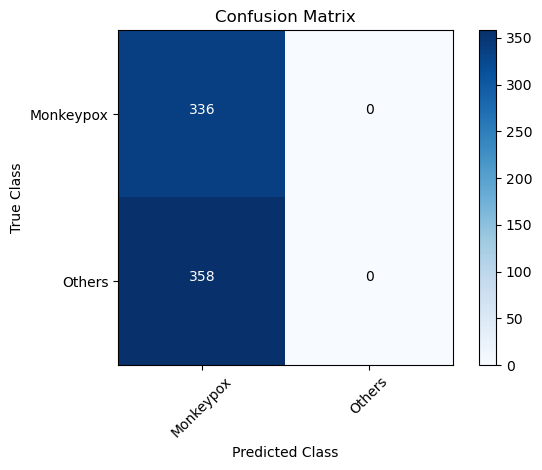

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

test_directory = 'data/MSID_BINARY_AUG_SP/test'

# Define your testing dataset using ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)  # Adjust any other preprocessing options as needed
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)


# Make predictions on the testing dataset
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.imshow(confusion, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
classes = test_generator.class_indices
class_names = list(classes.keys())
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Add labels to the matrix
thresh = confusion.max() / 2.0
for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
    plt.text(j, i, format(confusion[i, j], 'd'), horizontalalignment="center", color="white" if confusion[i, j] > thresh else "black")

plt.tight_layout()
plt.show()